# Part 1

In [1]:
import numpy as np
import matplotlib.pyplot as plt


Experimental Constants

In [14]:
BOLT_NUM = 17
FRAME_RATE = 240

Loading vibration Data

In [ ]:
data_dict = dict(np.load(r'data\\AutonomousTrajectoriesBig.npz'))
data_all = [it[1] for it in data_dict.items()]

In [5]:
data_dict.keys()

dict_keys(['T10', 'T11', 'T13', 'T20', 'T4', 'T18', 'T3', 'T14', 'T5', 'T17', 'T9', 'T23', 'T24', 'T21', 'T7', 'T6', 'T22', 'T12', 'T19', 'T15', 'T1', 'T2', 'T8', 'T16'])

In [8]:
print(len(data_all))
data_all[0].shape

24


(17, 7453)

# 1.1
 Reversing columns of the data matrices, so that data is in increasing time

In [ ]:
ordered_data_all = []
for data_mat in data_all:
    ordered_data_all.append(data_mat[:, ::-1])

# ensuring that the data is reversed correctly
for mat_reverse, mat_forward in zip(data_all, ordered_data_all):
    assert np.allclose(mat_reverse[:, ::-1], mat_forward)


In [ ]:
print(ordered_data_all[0][0, :])
print(data_all[0][0, :])
ordered_data_all[0].shape


[ 0.04094743  0.02806029  0.00584782 ...  0.0129485  -0.00066601
  0.00832467]
[ 0.00832467 -0.00066601  0.0129485  ...  0.00584782  0.02806029
  0.04094743]


31.054166666666667

At this point it's probably a good idea to visualise the data to get a clearer picture of the signal and any steady states

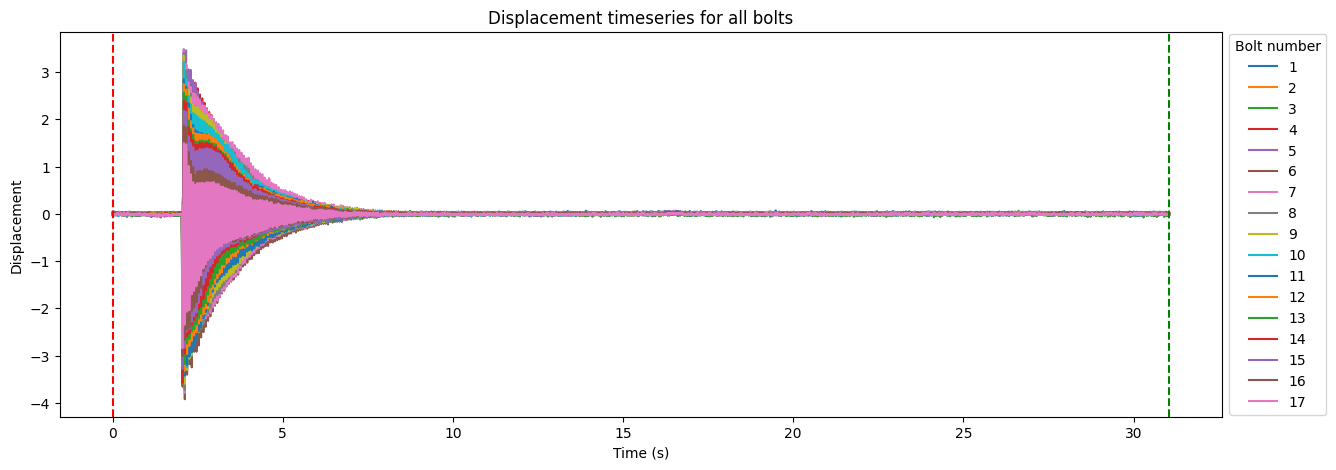

In [61]:
def get_time_from_frames(frames):
    t_final = frames / FRAME_RATE
    t = np.linspace(0, t_final, frames)
    return t

def plot_timeseries(data, start=0, stop=-1, fig_size=(15, 5), show_legend=True):
    fig, ax = plt.subplots(1, 1, figsize=fig_size)
    
    if stop == -1:
        stop = data.shape[1]

    # time of each measurement is determined based on the camera frame rate and the number of columns in the data array
    frame_count = data.shape[1]
    t = get_time_from_frames(frame_count)
    
    # t = t[start:stop+1]
    # plotting the timeseries data for each bolt
    for i in range(BOLT_NUM):
        ax.plot(t, data[i, :], label=f'{i+1}')
    
    ax.axvline(x=t[start], color='r', linestyle='--')
    ax.axvline(x=t[stop-1], color='g', linestyle='--')
    ax.set_xlabel('Time (s)')
    ax.set_ylabel('Displacement')

    if show_legend:
        ax.legend(title='Bolt number', loc='center left', bbox_to_anchor=(1, 0.5))
    
    plt.title('Displacement timeseries for all bolts')
    plt.show()

plot_timeseries(ordered_data_all[0], start=0, stop=-1)



# 1.3
Now let's ensure that each trajectory has zero mean (oscillation about 0 displacement). pesonally I feel it makes more sense to do this before clipping the trajectories

In [81]:
def zero_mean(data):
    return data - np.mean(data, axis=1, keepdims=True)

ordered_data = [zero_mean(data) for data in ordered_data_all]

# validating that zeroing the mean has worked
for data in ordered_data:
    assert np.allclose(np.mean(data, axis=1), 0, rtol=1e-15), 'Mean is not zeroed to machine precision'

# 1.2 
We can clearly see the initial steady state and the long time steady state from the above plot. We can remove these from the data matrix whilst keeping the no. of columns consistent for each test by calculating the absolute mean and std of the displacement at each timestep accross all bolts 

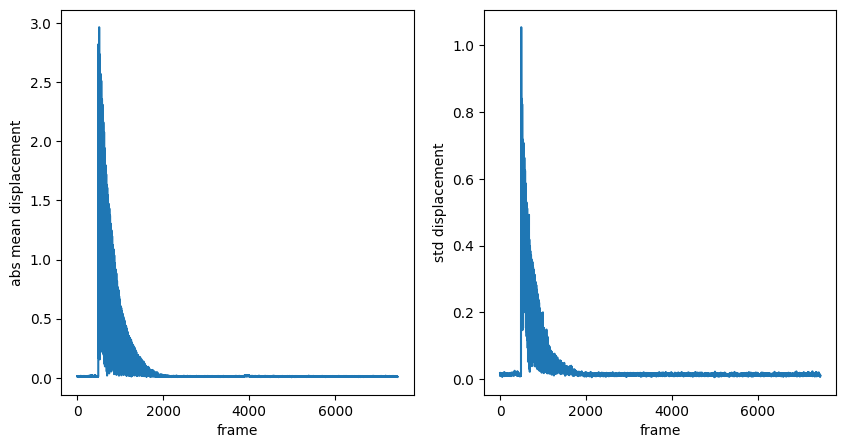

In [82]:
mean_series = np.mean(np.abs(ordered_data_all[0]), axis=0)
std_series = np.std(ordered_data_all[0], axis=0)

fig, axs = plt.subplots(1, 2, figsize=(10, 5))
axs[0].plot(mean_series)
axs[1].plot(std_series)
axs[0].set_xlabel('frame')
axs[0].set_ylabel('abs mean displacement')
axs[1].set_xlabel('frame')
axs[1].set_ylabel('std displacement')
plt.show()

So we can remove the steady state time by selecting points that exceed some minimum absolute mean and standard deviation. The problem is that some of the data matrices are noisier than others. A hacky way around this is that if we look at all of the data, every single experiment is definitely at a steady state after 20 seconds, so we can simply calculate the mean and std of the steady state for each matrix and use this as the threshold

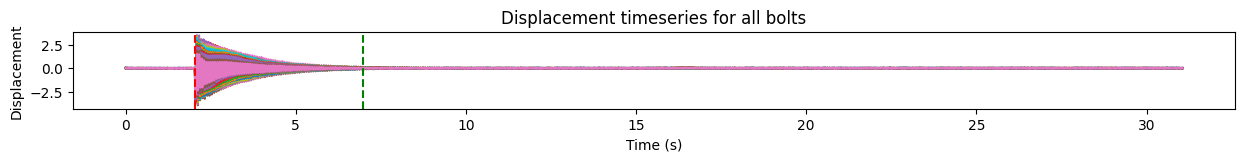

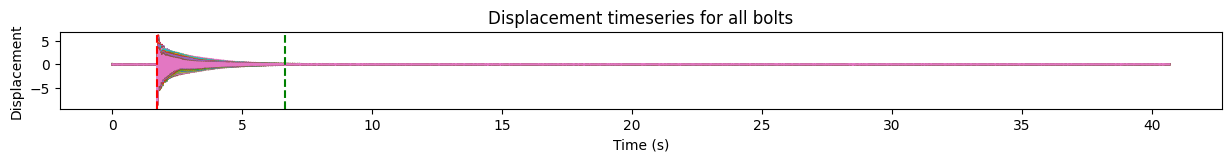

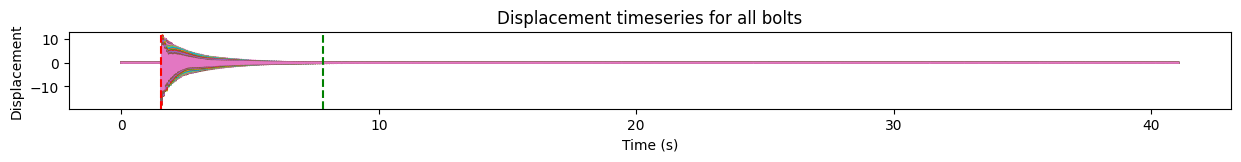

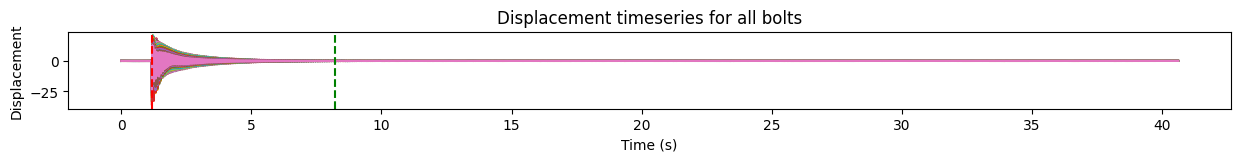

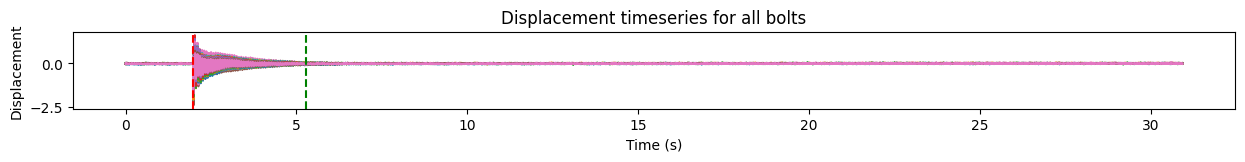

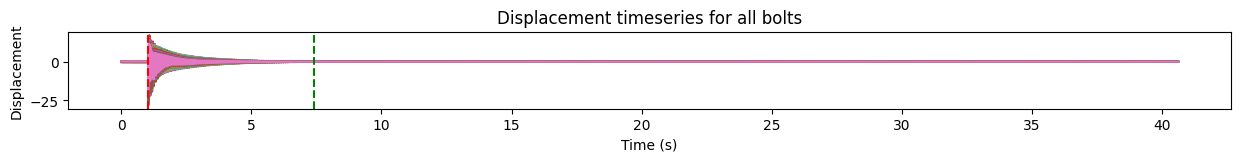

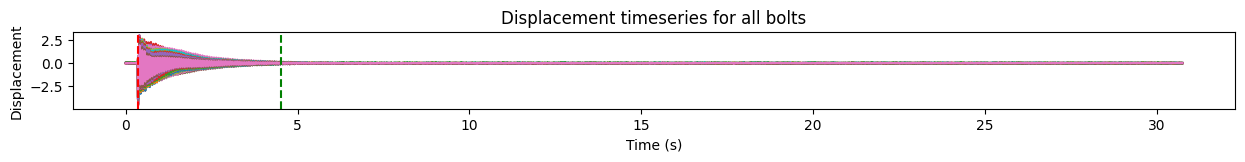

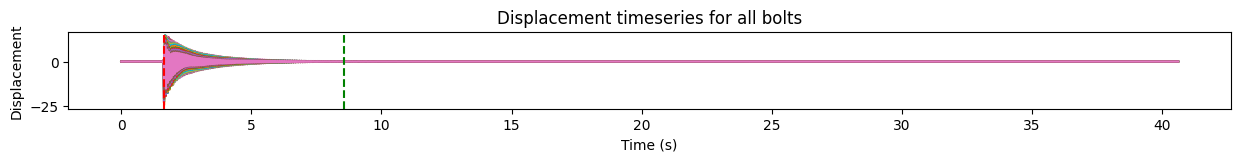

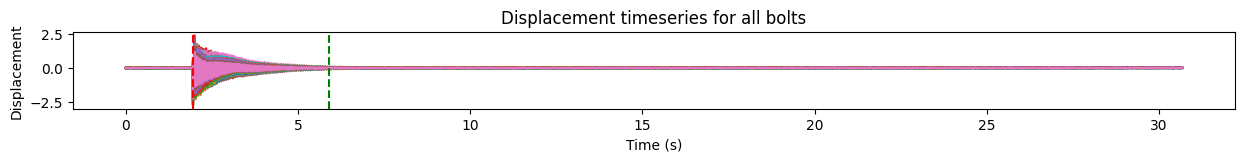

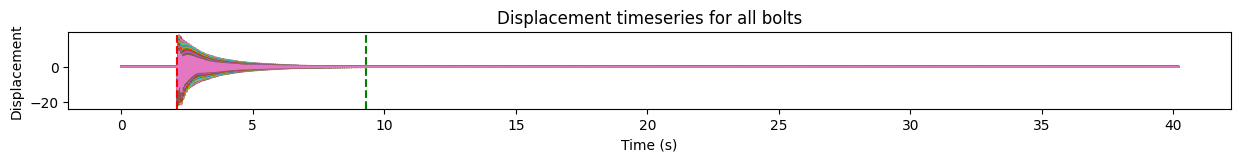

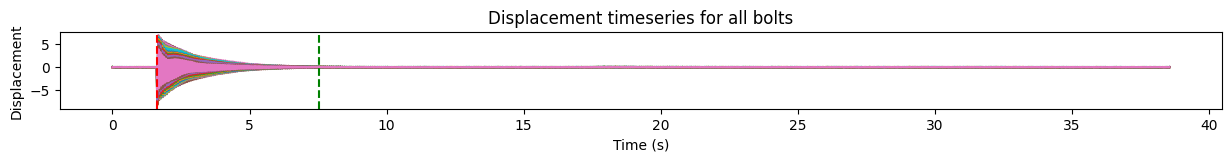

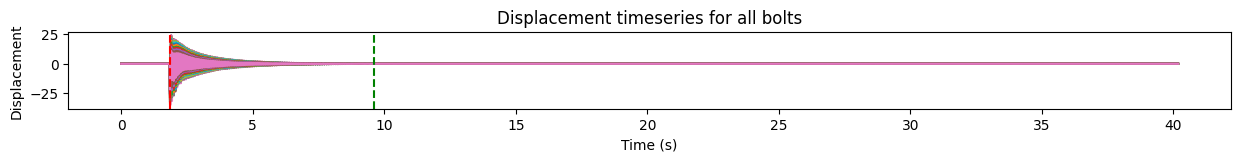

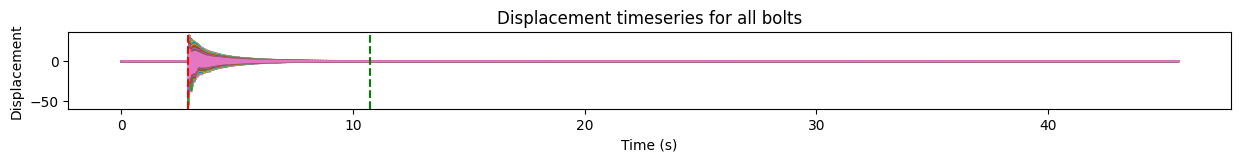

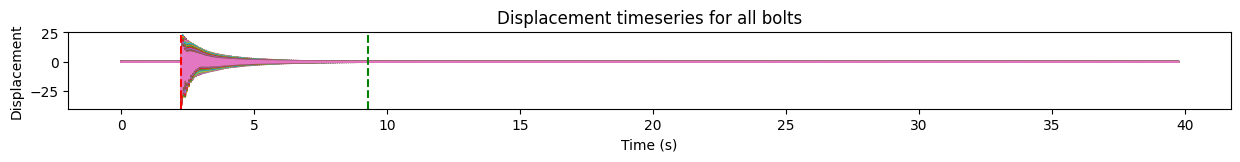

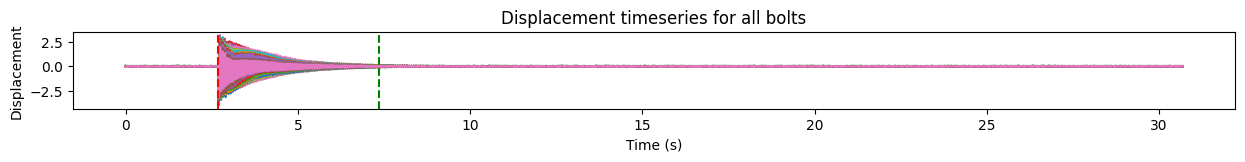

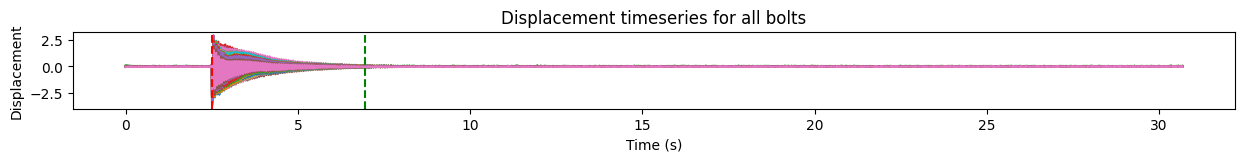

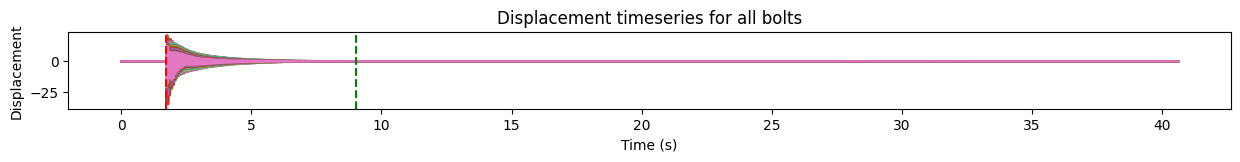

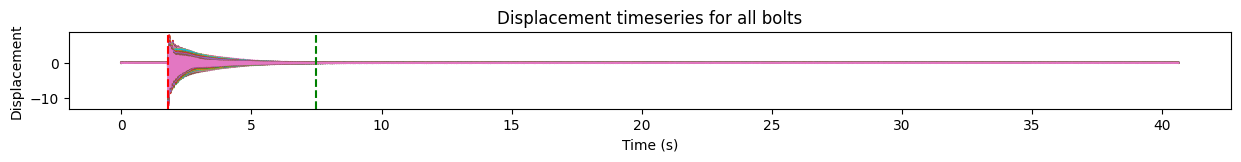

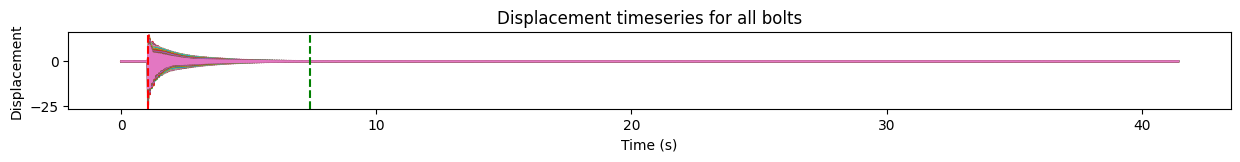

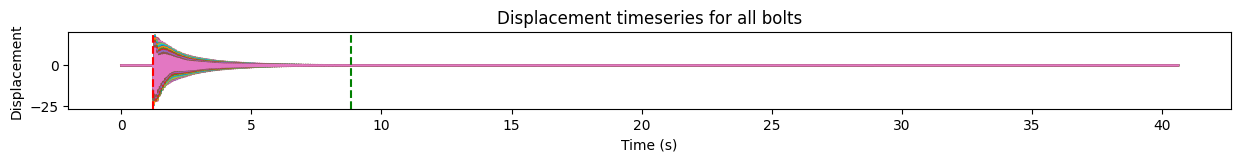

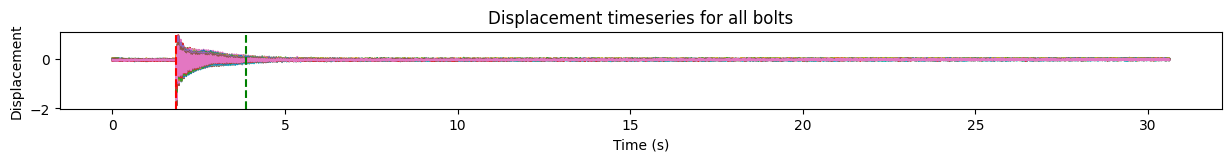

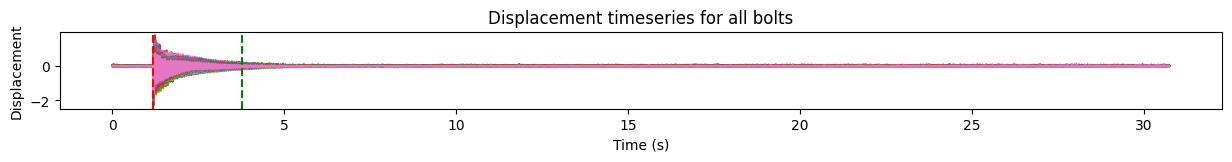

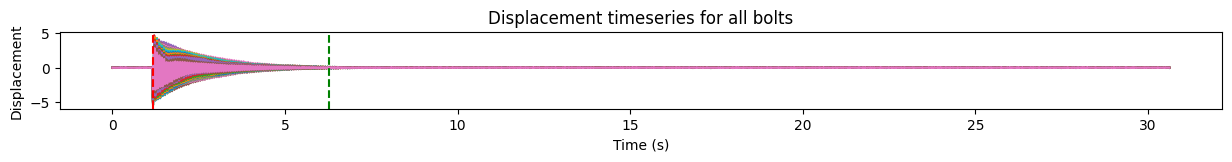

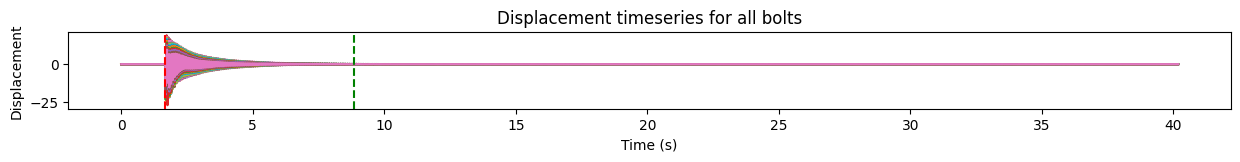

In [83]:
def find_steady_state(data):
    # timeseries of mean and std displacement across all bolts
    mean_series = np.mean(abs(data), axis=0)
    std_series = np.std(data, axis=0)
    
    # getting the maximum mean and std values accross each bolt after t=20s
    t = get_time_from_frames(data.shape[1])
    steady_start = np.where(t > 20)[0][0]
    mean_threshold = 1.4 * np.max(mean_series[steady_start:]) # fudge factor of 1.4 determined empirically
    std_threshold = 1.4 *np.max(std_series[steady_start:])
    
    # getting indices of the transient state using mean and std thresholds
    transient_mean = np.where(mean_series > mean_threshold)
    transient_std = np.where(std_series > std_threshold)
    transient_indices = np.intersect1d(transient_mean, transient_std)
    # stop at the last transient index
    stop = transient_indices[-1]
    # start index can be calculated in a more straightforward way
    max_mean = np.max(mean_series)
    start = np.where(mean_series > 0.05*max_mean)[0][0]

    return start, stop

# visually validating the start and stop positions
for data in ordered_data_all:
    start, stop = find_steady_state(data)
    plot_timeseries(data, start=start, stop=stop, fig_size=(15, 1), show_legend=False)




### 1.4
We do not know that the damping in the system is linear, therefore we cannot be certain that it is independent of the magnitude of displacement, so the rescaling should take place accross all matrices aggregated instead of individually. scaling values between 1 and -1 can be benificial for numerical stability. EXPAND ON THIS